In [1]:
import leaderbot as lb
import numpy
import numpy as np
import matplotlib.pyplot as plt
import texplot
import time
import scipy
import pickle
import pandas as pd
import statsmodels.api as sm
from copy import deepcopy
import texplot
from adjustText import adjust_text

In [2]:
# Load form file instead
filename = '../benchmark/models_train_full.pkl'
# filename = '../benchmark/models_train_full_both_ties.pkl'
#filename = '../benchmark/models_train_split.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

all_lb_models = results['models']
names = np.array(results['data']['models'])
agents = all_lb_models[0].agents

# models_indices = [1, 18, 23, 28]
models_indices = [i+1 for i in range(len(all_lb_models))]
lb_models = [all_lb_models[i-1] for i in models_indices]

In [3]:
# The following matches are grouped into "Confident", "Likely", "Speculative", "Unknown",
# "nan", and "unverified". These categories correpond to the column "Confidence" in the
# spreadsheet.

matches_conficent = {
    "Qwen1.5-110B": "qwen1.5-110b-chat",
    "Qwen-14B": "qwen-14b-chat",
    "Qwen-VL-Max": "qwen-max-0428",
    "Gemma 1.1 7B Instruct": "gemma-1.1-7b-it",
    "Gemma 2 9B": "gemma-2-9b-it",
    "Gemma 2 27B": "gemma-2-27b-it",
    "OLMo-7B": "olmo-7b-instruct",
    "Mixtral 8x7B": "mixtral-8x7b-instruct-v0.1",
    "Nemotron-4 340B": "nemotron-4-340b-instruct",
    "DeepSeek-Coder-V2 236B": "deepseek-coder-v2",
    "DeepSeek LLM 67B": "deepseek-llm-67b-chat",
    # "DeepSeek-V2.5": "deepseek-v2-api-0628",   ### NOT SURE THIS IS A VALID MATCH
    "GPT-4o": "gpt-4o-2024-05-13",
    "Llama 2-13B": "llama-2-13b-chat",
    "Llama 2-70B": "llama-2-70b-chat",
    "Llama 3-70B": "llama-3-70b-instruct",
    "Llama 3.1-405B": "llama-3.1-405b-instruct",
    "phi-3-small 7.4B": "phi-3-small-8k-instruct",
    "Arctic": "snowflake-arctic-instruct",
    "DBRX": "dbrx-instruct-preview",
    "Gemma 7B": "gemma-7b-it",
    "MPT-30B (base)": "mpt-30b-chat",
    "Qwen-7B": "qwen1.5-7b-chat",
    "Qwen2-72B": "qwen2-72b-instruct",
    "Falcon-180B": "falcon-180b-chat",  # looks like an outlier, but I keep it as the data is confident
}

matches_likely = {
    # "PaLM 2": "palm-2",  # looks like an outlier (so off) in plots. Do not keep as not confident, rather likely
    "phi-3-medium 14B": "phi-3-medium-4k-instruct",
    "Qwen1.5 72B": "qwen1.5-72b-chat",
    "GLM-4 (0116)": "glm-4-0116",
    "Reka Flash": "reka-flash-20240722",
    "Mistral Large 2": "mistral-large-2407",
}

matches_speculative = {
    # "Mistral 7B": "mistral-7b-instruct",  # alternative match: mistral-7b-instruct-v0.2
    "GPT-3.5 Turbo": "gpt-3.5-turbo-0125",  # Param: Table 1 in Microsoft's CODEFUSION paper: https://arxiv.org/pdf/2310.17680v1
    # "Claude 2": "claude-2.1",  # alternative match: claude-2.0, FLOPS is just computed based on H100 purchase spending speculation
    "Yi-34B": "yi-1.5-34b-chat",  # Has all three param, FLOPS, and Dataset size: https://arxiv.org/pdf/2403.04652
    # "Mistral Large": "mistral-large-2402",  # FOPS based on spending on H100
    # "GPT-4": "gpt-4-0613",  # FLOPS: 90% CI: 8.2E+24 to 4.4E+25 (base don public info), Dataset size: second hand info
    # "Reka Core": "reka-core-20240501",  # Very speculative
    # "Yi-Large": "yi-large",  # Very speculative
}

matches_unknown = {
    "Claude Instant": "claude-instant-1",
    "Claude": "claude-1",
    "Mistral Medium": "mistral-medium",
    "Claude 3 Haiku": "claude-3-haiku-20240307",
    "Claude 3 Sonnet": "claude-3-sonnet-20240229",
    "Claude 3 Opus": "claude-3-opus-20240229",
    "GPT-4 Turbo": "gpt-4-turbo-2024-04-09",
    "Gemini 1.5 Pro": "gemini-1.5-pro-api-0514",
    "GPT-4o mini": "gpt-4o-mini-2024-07-18",
}

matches_unverified = {
    "Llama 3-8B": "llama-3-8b-instruct",
    "Llama 3.1-8B": "llama-3.1-8b-instruct",
    "Llama 3.1-70B": "llama-3.1-70b-instruct",
}

matches_nan = {
    "Command R+": "command-r-plus",
}

# Combine all dictionaries into one
matches = {}
matches.update(matches_conficent)
matches.update(matches_likely)
# matches.update(matches_speculative)
# matches.update(matches_unknown)  # All values of this category are NaN
matches.update(matches_unverified)
matches.update(matches_nan)

print(len(matches))

33


In [4]:
df = pd.read_csv("large_scale_ai_models.csv")
df = df[['System', 'Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)', 'Confidence']]

In [5]:
filtered_df = df[df['System'].isin(matches)]

In [6]:
assert len(filtered_df) == len(matches)

In [7]:
numeric_cols = ['Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']

sorted_df = df.copy()

# sorted_df[numeric_cols] = sorted_df[numeric_cols].apply(np.log)
sorted_df[numeric_cols] = sorted_df[numeric_cols] #.apply(np.log)

rev_matches = {v:k for k,v in matches.items()}

score_names = []
rank_names = []

for model_index, lb_model in zip(models_indices, lb_models):

    scr = lb_model.scores()
    rnk_ = np.argsort(-scr).argsort() + 1

    rank_mapping = dict(zip(lb_model.agents, rnk_.tolist()))
    rank_mapping = {rev_matches[k]: v for k, v in rank_mapping.items() if k in rev_matches}
    
    score_mapping = dict(zip(lb_model.agents, lb_model.scores().tolist()))
    score_mapping = {rev_matches[k]: v for k, v in score_mapping.items() if k in rev_matches}

    score_name = "Score_" + str(model_index).zfill(2)
    score_names.append(score_name)

    rank_name = "Rank_" + str(model_index).zfill(2)
    rank_names.append(rank_name)
    
    sorted_df[score_name] = sorted_df['System'].map(score_mapping)
    sorted_df[rank_name] = sorted_df['System'].map(rank_mapping)

sorted_df = sorted_df.sort_values(by=score_names[-1], ascending=True)


def scale_score(df_, subset):
    filtered_df = df_.dropna(subset=[subset])
    
    min_score = df_[subset].min()
    max_score = df_[subset].max()
    
    # Scale and shift the Score_18 column to [-1, 1]
    df_.loc[~df_[subset].isna(), subset] = (
        2 * (df_.loc[~df_[subset].isna(), subset] - min_score) / (max_score - min_score) - 1)

for score_name  in score_names:
    scale_score(sorted_df, score_name)

In [8]:
from IPython.display import display

df_confident = sorted_df[sorted_df["Confidence"].isin(["Confident"])]
df_likely = sorted_df[sorted_df["Confidence"].isin(["Likely"])]
df_speculative = sorted_df[sorted_df["Confidence"].isin(["Speculative"])]
df_unknown = sorted_df[sorted_df["Confidence"].isin(["Unknown"])]
df_nan = sorted_df[sorted_df["Confidence"].isna()]
df_unverfied = sorted_df[sorted_df["Confidence"].isin(["Unverified"])]

with pd.option_context('display.max_rows', None):
    print('\n\nConfident -----------------------------------\n')
    display(df_confident.dropna(subset=[score_names[-1]]))
    
    print('\n\nLikely -----------------------------------\n')
    display(df_likely.dropna(subset=[score_names[-1]]))

    print('\n\nspeculative -----------------------------------\n')
    display(df_speculative.dropna(subset=[score_names[-1]]))

    print('\n\nuknown -----------------------------------\n')
    display(df_unknown.dropna(subset=[score_names[-1]]))

    print('\n\nnan -----------------------------------\n')
    display(df_nan.dropna(subset=[score_names[-1]]))

    print('\n\nUnverfied -----------------------------------\n')
    display(df_unverfied.dropna(subset=[score_names[-1]]))
    
# pd.reset_option('display.max_rows')



Confident -----------------------------------



,System,Parameters,Training compute (FLOP),Training dataset size (datapoints),Confidence,Score_01,Rank_01,Score_02,Rank_02,Score_03,...,Score_26,Rank_26,Score_27,Rank_27,Score_28,Rank_28,Score_29,Rank_29,Score_30,Rank_30
73,OLMo-7B,7.000000e+09,1.033200e+23,2.000000e+12,Confident,-1.000000,113.0,-1.000000,114.0,-1.000000,...,-0.134923,113.0,-1.000000,114.0,-1.000000,114.0,-1.000000,114.0,-1.000000,113.0
125,Qwen-14B,1.400000e+10,2.500000e+23,3.000000e+12,Confident,-0.768944,104.0,-0.580486,106.0,-0.568899,...,0.120233,105.0,-0.569743,105.0,-0.612603,107.0,-0.516761,103.0,-0.663279,107.0
132,Falcon-180B,1.800000e+11,3.760000e+24,2.625000e+12,Confident,-0.751824,103.0,-0.577361,105.0,-0.553062,...,-1.000000,128.0,-0.530477,100.0,-0.579615,105.0,-0.544727,105.0,-0.639409,105.0
68,Gemma 7B,8.538074e+09,3.070000e+23,6.000000e+12,Confident,-0.809424,107.0,-0.551152,103.0,-0.594619,...,0.134963,103.0,-0.561533,104.0,-0.539756,104.0,-0.552120,106.0,-0.632950,104.0
150,Llama 2-13B,1.300000e+10,1.600000e+23,1.500000e+12,Confident,-0.578315,93.0,-0.433876,96.0,-0.468836,...,0.203132,96.0,-0.473512,95.0,-0.449496,96.0,-0.378855,97.0,-0.455800,96.0
127,Qwen-7B,7.000000e+09,1.010000e+23,2.400000e+12,Confident,-0.556356,89.0,-0.349190,92.0,-0.436679,...,0.252989,92.0,-0.449414,93.0,-0.414222,94.0,-0.352718,94.0,-0.397576,93.0
161,MPT-30B (base),3.000000e+10,1.890000e+23,1.050000e+12,Confident,-0.660751,96.0,-0.403468,94.0,-0.460531,...,0.235454,93.0,-0.463976,94.0,-0.352189,91.0,-0.290170,92.0,-0.354812,92.0
64,Gemma 1.1 7B Instruct,8.540000e+09,3.074400e+23,6.000000e+12,Confident,-0.482260,85.0,-0.276950,88.0,-0.344936,...,0.297133,88.0,-0.348061,89.0,-0.271121,87.0,-0.209482,87.0,-0.246364,87.0
41,Arctic,4.800000e+11,3.834718e+23,3.500000e+12,Confident,-0.427403,80.0,-0.175875,81.0,-0.264566,...,0.357356,81.0,-0.258649,81.0,-0.161804,80.0,-0.097089,80.0,-0.135647,80.0
148,Llama 2-70B,7.000000e+10,8.100000e+23,1.500000e+12,Confident,-0.363647,75.0,-0.165937,80.0,-0.246891,...,0.362426,80.0,-0.247159,79.0,-0.157816,79.0,-0.074216,79.0,-0.118881,79.0




Likely -----------------------------------



,System,Parameters,Training compute (FLOP),Training dataset size (datapoints),Confidence,Score_01,Rank_01,Score_02,Rank_02,Score_03,...,Score_26,Rank_26,Score_27,Rank_27,Score_28,Rank_28,Score_29,Rank_29,Score_30,Rank_30
42,phi-3-medium 14B,1.400000e+10,4.032000e+23,4.800000e+12,Likely,-0.188474,63.0,0.057501,59.0,-0.047967,...,0.493095,59.0,-0.034690,61.0,0.065799,59.0,0.172317,59.0,0.146226,59.0
72,Qwen1.5 72B,7.200000e+10,1.300000e+24,NaN,Likely,0.030908,51.0,0.195684,51.0,0.098558,...,0.572387,50.0,0.120165,52.0,0.230212,49.0,0.338231,52.0,0.316910,51.0
76,GLM-4 (0116),NaN,1.200000e+25,1.000000e+13,Likely,0.286974,36.0,0.400138,35.0,0.320202,...,0.686845,35.0,0.345677,35.0,0.457463,33.0,0.562487,34.0,0.564920,33.0
48,Reka Flash,2.100000e+10,6.300000e+23,5.000000e+12,Likely,0.397414,31.0,0.504633,29.0,0.422068,...,0.739710,29.0,0.440066,29.0,0.512903,31.0,0.640592,30.0,0.632427,30.0
18,Mistral Large 2,1.230000e+11,2.130000e+25,NaN,Likely,0.772149,13.0,0.789421,13.0,0.759280,...,0.887642,13.0,0.783530,11.0,0.818295,13.0,0.890118,11.0,0.885669,11.0




speculative -----------------------------------



,System,Parameters,Training compute (FLOP),Training dataset size (datapoints),Confidence,Score_01,Rank_01,Score_02,Rank_02,Score_03,...,Score_26,Rank_26,Score_27,Rank_27,Score_28,Rank_28,Score_29,Rank_29,Score_30,Rank_30




uknown -----------------------------------



,System,Parameters,Training compute (FLOP),Training dataset size (datapoints),Confidence,Score_01,Rank_01,Score_02,Rank_02,Score_03,...,Score_26,Rank_26,Score_27,Rank_27,Score_28,Rank_28,Score_29,Rank_29,Score_30,Rank_30




nan -----------------------------------



,System,Parameters,Training compute (FLOP),Training dataset size (datapoints),Confidence,Score_01,Rank_01,Score_02,Rank_02,Score_03,...,Score_26,Rank_26,Score_27,Rank_27,Score_28,Rank_28,Score_29,Rank_29,Score_30,Rank_30
50,Command R+,1.040000e+11,NaN,NaN,NaN,0.3349,32.0,0.434485,32.0,0.353648,...,0.703075,32.0,0.377982,32.0,0.480685,32.0,0.593643,32.0,0.587346,32.0




Unverfied -----------------------------------



,System,Parameters,Training compute (FLOP),Training dataset size (datapoints),Confidence,Score_01,Rank_01,Score_02,Rank_02,Score_03,...,Score_26,Rank_26,Score_27,Rank_27,Score_28,Rank_28,Score_29,Rank_29,Score_30,Rank_30
21,Llama 3.1-8B,8.000000e+09,NaN,NaN,Unverified,0.137249,41.0,0.28329,41.0,0.190989,...,0.614654,42.0,0.222412,41.0,0.318138,40.0,0.444209,40.0,0.438429,40.0
20,Llama 3.1-70B,7.000000e+10,7.929000e+24,NaN,Unverified,0.741388,14.0,0.76832,14.0,0.722020,...,0.880534,14.0,0.754082,14.0,0.802178,14.0,0.871768,14.0,0.870232,14.0


# OLS: Isolated Individual Relation Between Parameters, FLOPs, and Datasize

In [8]:
# Log-transform the independent variables
X = deepcopy(sorted_df[['Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']]).apply(np.log)

ys = []
for score_name in score_names:
    ys.append(deepcopy(sorted_df[score_name]))

all_results = []
all_models = []
all_correlations = []

for y in ys:

    # Table to collect results
    results = []
    models = []
    correlations = []
    
    # Perform OLS for each input independently
    for column in X.columns:
    
        # Drop NaNs for the specific column and dependent variable
        X_y_individual = deepcopy(pd.concat([X[column], y], axis=1)).dropna()
        X_clean = deepcopy(X_y_individual[[column]])
        y_clean = deepcopy(X_y_individual[y.name])
    
        pearson = X_clean[column].corr(y_clean, method='pearson')
    
        # Add intercept
        X_clean = sm.add_constant(X_clean) 
    
        # Fit the model
        model = sm.OLS(y_clean, X_clean).fit()
        models.append(model)
        
        # Collect results
        results.append({
            "Variable": column,
            "Coeff x100": model.params[column] * 100,
            "Error x100": model.bse[column] * 100,
            "p-Value x100": model.pvalues[column] * 100,
            "R-Squared": model.rsquared,
            "Pearson": pearson,
        })
    
    pd.set_option('display.expand_frame_repr', False)  # Prevent column wrapping
    pd.set_option('display.max_columns', None)        # Display all columns
    pd.set_option('display.width', 1000)              # Increase display width to fit more columns
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    print(results_df)
    print('-----')

    all_results.append(results)
    all_models.append(models)

                             Variable  Coeff x100  Error x100  p-Value x100  R-Squared   Pearson
0                          Parameters   14.110310    6.524262      3.894474   0.138890  0.372679
1             Training compute (FLOP)   24.905752    4.013854      0.000173   0.606308  0.778658
2  Training dataset size (datapoints)   47.379127    9.748502      0.007396   0.517766  0.719560
-----
                             Variable  Coeff x100  Error x100  p-Value x100  R-Squared   Pearson
0                          Parameters   13.106308    5.879637      3.371710   0.146278  0.382463
1             Training compute (FLOP)   22.121313    3.739823      0.000358   0.583250  0.763708
2  Training dataset size (datapoints)   42.934901    9.066777      0.010017   0.504773  0.710474
-----
                             Variable  Coeff x100  Error x100  p-Value x100  R-Squared   Pearson
0                          Parameters   13.200372    5.725592      2.848658   0.154897  0.393570
1             Trai

In [9]:
# Count the number of non-NaN entries for each column in X and y
counts = {
    column: pd.concat([X[column], y], axis=1).dropna().shape[0]
    for column in X.columns
}

print(counts)

{'Parameters': 31, 'Training compute (FLOP)': 27, 'Training dataset size (datapoints)': 24}


In [10]:
# Compute the mean and deviation of all rankings across rank columns of sorted_df
rnks = []
for rank_name in rank_names:
    rnks.append(deepcopy(sorted_df[rank_name]))

rnk_mean = sorted_df[rank_names].mean(axis=1)

# Rank deviation
# rnk_dev = sorted_df[rank_names].std(axis=1)
# rnk_dev = sorted_df[rank_names].apply(lambda row: (row - row.mean()).abs().mean(), axis=1)
rnk_dev = sorted_df[rank_names].apply(lambda row: row.max() - row.min(), axis=1)

rnk_mean.name = "rnk_mean"
rnk_dev.name = "rnk_dev"

# Adding the mean and deviation of ranks to the dataframe
sorted_df["rnk_mean"] = rnk_mean
sorted_df["rnk_dev"] = rnk_dev

Plot saved to "/home/sia/work/github/leaderbot/notebooks/epoch_ai_var.svg".
Plot saved to "/home/sia/work/github/leaderbot/notebooks/epoch_ai_var.pdf".


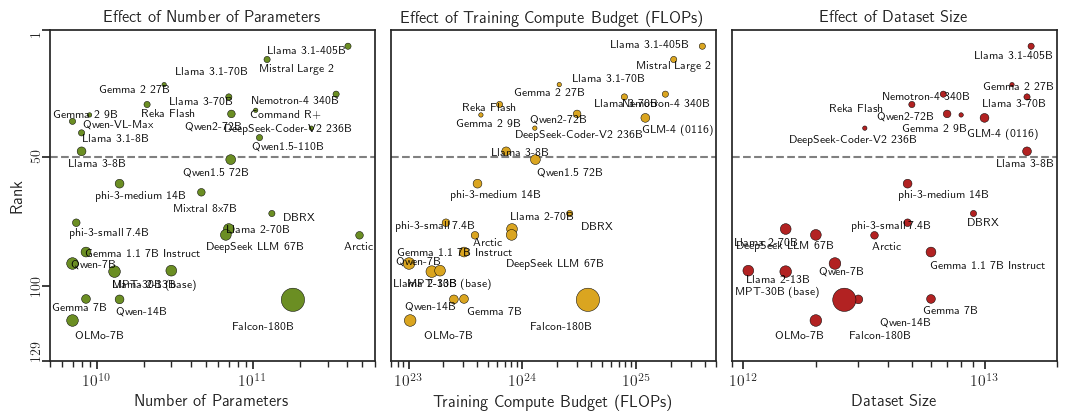

In [14]:
use_latex = True
save = True

bg_color = 'none'
fg_color = 'black'

with texplot.theme(use_latex=use_latex, font_scale=1, rc={'font.family': 'sans-serif'}):

    # Plot scatter plots and regression lines
    # fig, axes = plt.subplots(ncols=3, figsize=(15, 4.5), sharey=True)
    fig, axes = plt.subplots(ncols=3, figsize=(13, 4.3), sharey=True)
    
    titles = ['Effect of Number of Parameters', 'Effect of Training Compute Budget (FLOPs)', 'Effect of Dataset Size']
    xlabels = ['Number of Parameters', 'Training Compute Budget (FLOPs)', 'Dataset Size']

    colors = ['olivedrab', 'darkgoldenrod', 'maroon']
    colors = ['olivedrab', 'goldenrod', 'firebrick']

    axes[0].set_xlim([5e9, 6e11])
    axes[1].set_xlim([7e22, 5e25])
    axes[2].set_xlim([9e11, 2e13])
    
    for ax, column, model, title, color, xlabel in zip(axes, X.columns, models, titles, colors, xlabels):
        # Drop NaNs for plotting

        # for rnk in rnks:
        #     X_y_individual = deepcopy(pd.concat([X[column], rnk], axis=1)).dropna()
        #     X_clean = deepcopy(X_y_individual[[column]])
        #     y_clean = deepcopy(X_y_individual[rnk.name])
        
        #     # Exponentiate the data to revert log transformation for plotting
        #     x_actual = np.exp(X_clean[column])  # Original values
        #     y_actual = y_clean
        
        #     # Scatter plot with labels for systems
        #     ax.scatter(x_actual, y_actual, alpha=1, label="Data points", color=color,
        #                edgecolors='black', linewidths=0.35, s=3)

        X_y_individual = deepcopy(pd.concat([X[column], rnk_mean, rnk_dev], axis=1)).dropna()
        X_clean = deepcopy(X_y_individual[[column]])
        y_clean = deepcopy(X_y_individual[rnk_mean.name])
        r_clean = deepcopy(X_y_individual[rnk_dev.name])
    
        # Exponentiate the data to revert log transformation for plotting
        x_actual = np.exp(X_clean[column])  # Original values
        y_actual = y_clean
    
        # Scatter plot with labels for systems
        ax.scatter(x_actual, y_actual, alpha=1, label="Data points", color=color,
                   edgecolors=fg_color, linewidths=0.35, s=r_clean*10)

        # texts = []
        labels = []
        for i, (x_val, y_val) in enumerate(zip(x_actual, y_actual)):
            system_label = sorted_df.loc[X_y_individual.index[i], 'System']
            labels.append(system_label)
            # texts.append(ax.text(np.log(x_val), y_val, system_label, fontsize=8, alpha=0.9, ha='center'))

        # # Regression line
        # x_vals = np.linspace(X_clean[column].min() - 1.5, X_clean[column].max() + 1.5, 100)
        # x_vals_with_intercept = sm.add_constant(pd.DataFrame({column: x_vals}))
        # y_vals = model.predict(x_vals_with_intercept)
        # x_vals_original = np.exp(x_vals)  # Revert log transformation for x-axis
        # ax.plot(x_vals_original, y_vals, '--', color='black', label="Regression")

        # # Confidence interval
        # pred_summary = model.get_prediction(x_vals_with_intercept).summary_frame(alpha=0.05)
        # ci_lower = pred_summary["mean_ci_lower"]
        # ci_upper = pred_summary["mean_ci_upper"]
        # ax.fill_between(x_vals_original, ci_lower, ci_upper, color=color, alpha=0.2, label="95\% CI")

        # # Add pronounced edges for the confidence interval
        # ax.plot(x_vals_original, ci_lower, color=color, linewidth=1, linestyle='-', alpha=0.4)
        # ax.plot(x_vals_original, ci_upper, color=color, linewidth=1, linestyle='-', alpha=0.4)

    
        # Customize plot
        ax.set_xlabel(xlabel)
        # ax.legend(fontsize='x-small', loc='lower right')
        ax.set_title(title)
    
        # Set log scale for x-axis
        ax.set_xscale('log')
        ax.axhline(50, linestyle='--', color='gray', zorder=-10)

        ax.set_ylim([1, 129])



        # ==========
        # Create a temporary axes to plot adjust_text, which plots texts with adjusted non-overlapping coordinates
        # but in (log(x), y), since the adjust_text package does not work well with set_scale)'log'). So, instead,
        # we trick it to get x coordinates that are the log of the ctual x. Once adjust_text computed the coordinates.
        # we return the adjusted x coordinates back to exp(x), and we remove the temporary axes.

        temp_ax = fig.add_axes(ax.get_position(), frameon=False)  # No border
        temp_ax.set_xlim(np.log(ax.get_xlim()))  # Set log-space limits
        temp_ax.set_ylim(ax.get_ylim())  # Match y-limits
        
        # Hide the temporary axis
        temp_ax.set_axis_off()

        temp_sc = temp_ax.scatter(np.log(x_actual), y_actual, alpha=1, label="Data points", color=color, edgecolors='black', linewidths=0.35, s=r_clean*40.0)

        # texts = []
        # # for x_val, y_val, label in zip(x_log, y_actual, labels):
        # for x_val, y_val, label in zip(x_vals, y_actual, labels):
        #     texts.append(temp_ax.text(x_val, y_val, label, fontsize=8))

        texts = []
        for i, (x_val, y_val) in enumerate(zip(x_actual, y_actual)):
            system_label = sorted_df.loc[X_y_individual.index[i], 'System']
            texts.append(temp_ax.text(np.log(x_val), y_val, system_label, fontsize=8, alpha=0.9, ha='center'))

        adjust_text(
            texts, time_lim=10, ensure_inside_axes=True,
            arrowprops=None,
            ax=temp_ax, objects=temp_sc, 
            force_text=0.04,  # Reduce repulsion between texts
            force_points=0.04,  # Reduce repulsion between text and points
            max_move=0.04,  # Limit maximum movement
        )

        # Extract adjusted positions and apply them to the original axis
        for text, x_val, y_val in zip(texts, x_actual, y_actual):
            x_adj, y_adj = text.get_position()
            ax.text(np.exp(x_adj), y_adj, text.get_text(), fontsize=8, alpha=0.9, ha='center', color=fg_color)

        temp_ax.remove()

        # ==============

    axes[0].invert_yaxis()
    axes[1].invert_yaxis()
    axes[2].invert_yaxis()
    
    # Only leftmost subplot has y-ticks and y-label
    for ax in axes[1:]:
        ax.tick_params(left=False, labelleft=False)
    axes[0].set_ylabel("Rank")
    axes[0].set_yticks([1, 50, 100, 129])
    
    axes[0].tick_params(axis='y', labelrotation=90)

    for label in axes[0].get_yticklabels():
        y_pos = label.get_position()[1]
        if y_pos == axes[0].get_ylim()[0]:
            label.set_verticalalignment('bottom')
        elif y_pos == axes[0].get_ylim()[1]:
            label.set_verticalalignment('top')
        else:
            label.set_verticalalignment('center')
        label.set_horizontalalignment('center')
        label.set_fontsize(10)

    plt.subplots_adjust(wspace=0.05) 

    # Foreground color
    if fg_color != 'black':

        for ax in axes:

            # Change axis spine colors
            ax.spines['bottom'].set_color(fg_color)
            ax.spines['top'].set_color(fg_color)
            ax.spines['left'].set_color(fg_color)
            ax.spines['right'].set_color(fg_color)

            # Change tick color
            ax.tick_params(axis='both', which='both', colors=fg_color)

            # Change label color
            ax.xaxis.label.set_color(fg_color)
            ax.yaxis.label.set_color(fg_color)

            # Change title color
            ax.title.set_color(fg_color)

    # Background color
    if bg_color == 'none':
        transparent_bg = True
    else:
        fig.set_facecolor(bg_color)
        for ax in axes:
            ax.set_facecolor(bg_color)
        transparent_bg = False

    texplot.show_or_save_plot(plt, default_filename='epoch_ai_var',
                              transparent_background=transparent_bg, dpi=200,
                              show_and_save=save, verbose=True)

In [13]:
X = deepcopy(sorted_df[['Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']]).apply(np.log)
data = deepcopy(pd.concat([X, rnk_mean, rnk_dev], axis=1)).dropna()

model1 = sm.OLS(data['rnk_dev'], sm.add_constant(data['rnk_mean'])).fit()
model2 = sm.OLS(data['rnk_dev'], sm.add_constant(data[['Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']])).fit()
model3 = sm.OLS(data['rnk_dev'], sm.add_constant(data[['rnk_mean', 'Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']])).fit()

print("Model 1 (y ~ z):")
print(model1.summary())
print('\n\n\n\n\n\n')

print("\nModel 2 (y ~ x1 + x2 + x3):")
print(model2.summary())
print('\n\n\n\n\n\n')

print("\nModel 3 (y ~ z + x1 + x2 + x3):")
print(model3.summary())

Model 1 (y ~ z):
                            OLS Regression Results                            
Dep. Variable:                rnk_dev   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     7.958
Date:                Wed, 25 Dec 2024   Prob (F-statistic):             0.0102
Time:                        18:38:51   Log-Likelihood:                -67.401
No. Observations:                  23   AIC:                             138.8
Df Residuals:                      21   BIC:                             141.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9785      2.269   

In [14]:
f_test_result = model1.compare_f_test(model2)
print(f"F-test p-value: {f_test_result[1]}")


F-test p-value: nan


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_full = sm.add_constant(data[['rnk_mean', 'Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']])
vif = pd.DataFrame({
    "Variable": X_full.columns,
    "VIF": [variance_inflation_factor(X_full.values, i) for i in range(X_full.shape[1])]
})
print(vif)


                             Variable          VIF
0                               const  4821.517539
1                            rnk_mean     2.665910
2                          Parameters     3.608560
3             Training compute (FLOP)     5.946316
4  Training dataset size (datapoints)     3.091650


In [16]:
from sklearn.linear_model import Ridge

X = data[['rnk_mean', 'Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']]
y = data['rnk_dev']
ridge = Ridge(alpha=1.0).fit(X, y)
print("Ridge coefficients:", ridge.coef_)
print("Ridge score (R^2):", ridge.score(X, y))


Ridge coefficients: [ 0.14512706 -0.90489225  3.07645971 -1.93310535]
Ridge score (R^2): 0.5418964563723847


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

cv_model = LinearRegression()
scores = cross_val_score(cv_model, X, y, cv=5, scoring='r2')
print("Cross-validated R^2:", scores.mean())


Cross-validated R^2: -50.93046765620567


In [18]:
correlation_matrix = data[['rnk_mean', 'Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']].corr()
print(correlation_matrix)


                                    rnk_mean  Parameters  Training compute (FLOP)  Training dataset size (datapoints)
rnk_mean                            1.000000   -0.374083                -0.700429                           -0.710679
Parameters                         -0.374083    1.000000                 0.741648                            0.106220
Training compute (FLOP)            -0.700429    0.741648                 1.000000                            0.594010
Training dataset size (datapoints) -0.710679    0.106220                 0.594010                            1.000000
